In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

## Robust Regression and Economic Modeling

Before we go and set you loose on an economic or social science model of your own choosing, let's briefly compare our new form of linear modeling, robust regression, with our previous methods, specifically simple linear regression.

To do this we'll use economic data from The St. Louis Federeal Reserve for GDP and unemployment. Specifically, let's propose the following specification:

$$   GDP growth = \alpha + \beta_{1} \Delta Unemployment $$

We have that dataset prepared, quarterly since 1970. Let's look at it below.

In [2]:
econ_data = pd.read_csv('assets/economic_data.csv')
econ_data.set_index(econ_data['DATE'], inplace=True)
del econ_data['DATE']

#Annualize our unemployment delta by multiplying by 4 (a crude but sufficient method for here)
econ_data['Unemployment_chg'] = econ_data.Unemployment.diff()*4
econ_data.dropna(inplace=True)

econ_data.head()

,Unemployment,GDP_pct_chg,Unemployment_chg
DATE,,,
1970-04-01,4.8,0.7,2.4
1970-07-01,5.3,3.6,2.0
1970-10-01,5.8,-4.0,2.0
1971-01-01,6.0,11.1,0.8
1971-04-01,6.0,2.3,0.0


Now, the economic reasoning motivating our model is this: as an economy slows, people are more likely to be unemployed. When an economic is growing rapidly, more people should get jobs and unemployment should decrease.

But is that logic true?

Our model will be able to test for a linear relationship between these factors. Let's check the simple linear model first.

In [3]:
from sklearn.linear_model import LinearRegression
lm = LinearRegression()

X = pd.DataFrame(econ_data.Unemployment_chg)
y = list(econ_data.GDP_pct_chg)

lm.fit(X,y)
print('coefficients: ' + str(lm.coef_))
print('intercept: ' + str(lm.intercept_))
print('score: ' + str(lm.score(X,y)))

coefficients: [-1.47237427]
intercept: 2.83440480346
score: 0.387806342953


/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/scipy/linalg/basic.py:884: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  warnings.warn(mesg, RuntimeWarning)


This seems to show a strong negative relationship, as we expected.

Let's look at both a time series and a scatter plot.

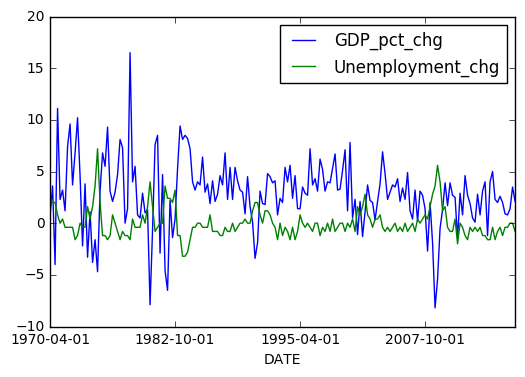

In [4]:
econ_data[['GDP_pct_chg', 'Unemployment_chg']].plot()
plt.show()

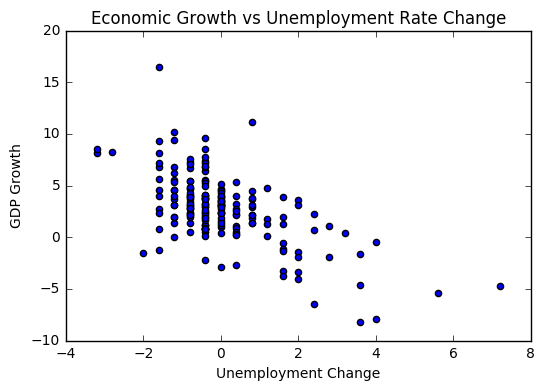

In [5]:
plt.scatter(x = econ_data.Unemployment_chg, y = econ_data.GDP_pct_chg)
plt.title('Economic Growth vs Unemployment Rate Change')
plt.xlabel('Unemployment Change')
plt.ylabel('GDP Growth')
plt.show()

Now, to an economist this graph tells some familiar stories. 

The main story is the logic we outlined previously. As GDP grows faster, unemployment tends to decline and vice versa, However, particularly in the time series, another story is apparent. 

That story is about the 70s and early 80s. This was an interesting period, both for monetary policy and economic history. Specifically, the economy was not in a great place, particularly in the late seventies and early eighties, leading to one of the great monetary experiments of our time *(or really of any time)* in aggressive changes to the federal funds . This creates a period of what could be classified as an outlier. Values went all over the place and there was an external factor that was creating a massive effeect in our included variables. However, let's say we don't want to complicate our model for some reason so we don't want to include that additional data.

Let's look to see if a boxplot shows strong indication of these outliers.



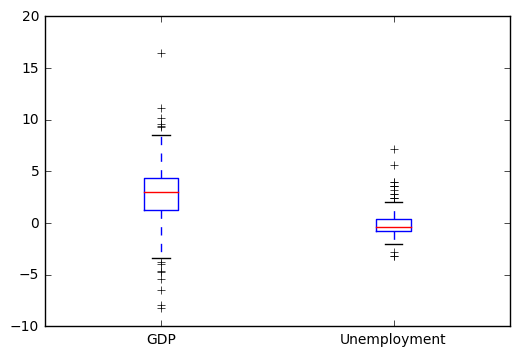

In [6]:
plt.boxplot([econ_data.GDP_pct_chg, econ_data.Unemployment_chg])
plt.xticks([1,2], ['GDP','Unemployment'])
plt.show()

Both of these boxplots show a pretty significant number of outliers, particularly given their relatively small sample sizes. Those outliers need to be addressed in some way.

But what can we do if we don't want to just delete those time periods?

Well, robust regression offers an option. This will weight our outliers less, giving us a more stable and accurate model. Here we'll use Huber weighting, which offers us a way to limit the impact of outliers while still extracting information from them. We also avoid skewing our results, since it appears, particularly in Unemployment, that outliers are more likely in one direction than the other.

Let's see if anything changes.

In [7]:
from sklearn.linear_model import HuberRegressor
hr = HuberRegressor()

hr.fit(X,y)
print('coefficients: ' + str(hr.coef_))
print('intercept: ' + str(hr.intercept_))
print('score: ' + str(hr.score(X,y)))

coefficients: [-1.34847355]
intercept: 2.80422218697
score: 0.384985795358


Now our robust regression gives a pretty significantly lower coefficient for our relationship, suggesting that 1.37% increase in GDP results from a 1% decrease in unemployment. Note that the score is slightly lower, but that fitting to the outliers can actually be considered a form of overfitting, so that decrease is not necessarily problematic.

Below is a visualization of the two lines.

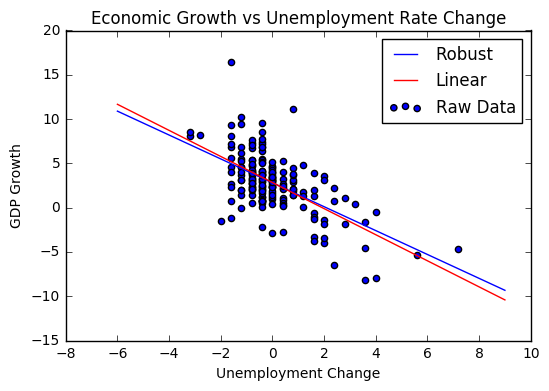

In [26]:
robust = [hr.coef_[0] * i + hr.intercept_ for i in range(-6, 10)]
linear = [lm.coef_[0] * i + lm.intercept_ for i in range(-6, 10)]

plt.scatter(x = econ_data.Unemployment_chg, y = econ_data.GDP_pct_chg, label='Raw Data')
plt.plot(range(-6,10), robust, label='Robust')
plt.plot(range(-6,10), linear, 'r', label='Linear')
plt.legend()
plt.title('Economic Growth vs Unemployment Rate Change')
plt.xlabel('Unemployment Change')
plt.ylabel('GDP Growth')
plt.show()

## Okun's Law

What we've actually been exploring here is a known economic relationship, called Okun's law. Now, there are multiple ways to investigate this relationship, and many things you can attempt to control for with additional variables in your regression, but the crux of it is this.

For each 1% an economy wishes to change unemployment, you will need a 2% change in GDP from it's natural rate of growth. By natural rate of growth what we're referring to is the growth in GDP effectively from population increase. It would have to grow faster than that to start to effect unemployment. You can also think of it as implying that if GDP did not change, unemployment would increase simply from population growth.

Functionally, this natural growth rate is our intercept, or $\alpha$. Here it is implied to be approximatly 2.8% GDP growth just to maintain employment levels. Note that that is quite different than standards suggest. Another alteration can be applied to the model to force it to a more commonly accepted, 2% standard natural growth rate of GDP. You can do this by normalizing GDP to the distance from 2%, and then not fitting an intercept to your model. This will force our best fit linear relationship through an origin representing the natural growth of GDP.

Economics in particular but social science in general is very fond of using linear models to explain simple relationships that are suggested from logic. This is just one such example. The Cobb Douglas production function we discussed earlier would be another.

## Drill

How does this compare to other linear regression varieties?

Run some of the other linear regressions you learning in the advanced linear regression section and compare them to the two we did here. What are the philosophical reasons you might prefer one to the other? Remember to think about model stability by trying your model on different subsets of the data and seeing how your coefficients change. This is a key point in this kind of interpretable model building.